# Stochastic Variance Reduction Methods for Policy Evaluation

## Convex Optimization: Project

### Team Members:

- Gautham Bellamkonda
- Pranav Kalsanka Nayak


# Problem Statement

Consider the minimization of objective in equation (7) in https://proceedings.mlr.press/v70/du17a/du17a.pdf. Find a dual of min (7) by eliminating $\theta$ from equation (10). Highlight the formula for computing the primal solution using the dual solution. Since the primal and dual are unconstrained quadratics, one can solve them using accelerated gradient descent. Note that the per iteration cost is $O(nd^2)$ (assume $n\ge d$) for both primal and dual algos. We already know for reaching $\epsilon$ optimal solution we need $\log(\frac{1}{\epsilon})$ iterations. The paper proposes to solve something "in-between" the primal and dual (saddle-point form), which is equation (10). This problem has both primal and dual variables. The idea is to perform block coordinate (gradient based) descent\&ascent  on primal\&dual variables. The algorithm is in equation (12). The advantage is computing (12) requires only $O(nd)$. Interestingly, in theorem~1, they show this algorithm  also has linear convergence i.e., for reaching $\epsilon$ optimal solution we need $\log(\frac{1}{\epsilon})$ iterations. Thus primal and dual algorithms shall be worse than the proposed primal-dual algorithm.


### a

Derive a dual of min (7) by eliminating $\theta$ from equation (10). Highlight the formula for computing the primal solution using the dual solution.

Equation (7) describes the minimization objective:

$$
\text{MSPBE}(\theta) = \frac{1}{2} \| \hat A \theta - \hat b \|^2_{\hat C^{-1}} + \frac{\rho}{2} \| \theta \|^2
$$

To minimize this objective with respect to $\theta$, we introduce the dual variable $w$ and write the Lagrangian as:

$$
\mathcal{L}(\theta, w) = \frac{\rho}{2} \| \theta \|^2 - w^T \hat A \theta - (\frac{1}{2} w^T \hat C w - w^T \hat b)
$$

<!-- Minimizing MSPBE with respect to $\theta$ is equivalent to solving  -->

<!-- $$ -->
<!-- % \min_{\theta} \max_{w} \mathcal{L}(\theta, w) -->
<!-- % $$ -->

Taking the gradient of $\mathcal{L}(\theta, w)$ with respect to $\theta$ and setting it to zero, we get:

\begin{align*}
\rho \theta - \hat A^T w &= 0\\
\theta &= \frac{\hat A^T w}{\rho}
\end{align*}

Substituting this back into the Lagrangian, we get the dual objective:

\begin{align*}
\max_{w} g(w) &= \max_{w} -\frac{1}{2 \rho} w^T \hat A \hat A^T w - (\frac{1}{2} w^T \hat C w - w^T \hat b)\\
&= \max_{w} -\frac{1}{2 \rho} w^T \hat A \hat A^T w - \frac{1}{2} w^T \hat C w + w^T \hat b\\
&= \max_{w} -\frac{1}{2 \rho} w^T (\hat A \hat A^T + \rho \hat C) w + w^T \hat b\\
&= \min_{w} \frac{1}{2 \rho} w^T (\hat A \hat A^T + \rho \hat C) w - w^T \hat b
\end{align*}

The primal solution can be computed using the dual solution as:

$$
\theta^* = \frac{\hat A^T w^*}{\rho}
$$


In [1]:
# code accelerated gradient descent for the primal problem

import numpy as np
import matplotlib.pyplot as plt
import time

#### c

Create a synthetic dataset as outlined in second para in section 8.

In [2]:
# MDP with 400 states and 10 actions. 

NUM_STATES = 400
NUM_ACTIONS = 10
GAMMA = 0.95

# states are represented by 201 dimensional vectors, where the first 200 dimensions are sampled from U[0, 1]
# the last dimension is 1
states = np.random.rand(NUM_STATES, 200)
states = np.concatenate((states, np.ones((NUM_STATES, 1))), axis=1)

# transition probabilities are sampled from U[0, 1]

transition_prob = np.random.rand(NUM_STATES, NUM_ACTIONS, NUM_STATES) + 1e-5
transition_prob = transition_prob / np.sum(transition_prob, axis=2, keepdims=True)

# policy is sampled from U[0, 1]
policy = np.random.rand(NUM_STATES, NUM_ACTIONS) + 1e-5
policy = policy / np.sum(policy, axis=1, keepdims=True)

# start distribution is sampled from U[0, 1]
start_distribution = np.random.rand(NUM_STATES) + 1e-5
start_distribution = start_distribution / np.sum(start_distribution)

# reward function is sampled from U[0, 1]
reward = np.random.rand(NUM_STATES, NUM_ACTIONS) + 1e-5

# sample transitions for T = 20_000
T = 20_000
A = np.zeros((201, 201))
b = np.zeros(201)
C = np.zeros((201, 201))

state = np.random.choice(NUM_STATES, p=start_distribution)
for t in range(T):
    action = np.random.choice(NUM_ACTIONS, p=policy[state])
    next_state = np.random.choice(NUM_STATES, p=transition_prob[state, action])
    r = reward[state, action]
    A += np.outer(states[state], states[state] - GAMMA * states[next_state])
    b += r * states[state]
    C += np.outer(states[state], states[state])
    state = next_state

A /= T
b /= T
C /= T

In [3]:
n = 201

rho = 0.1

hessian = A.T @ np.linalg.pinv(C) @ A + rho * np.eye(n)
eigvals = np.linalg.eigvals(hessian)
L = L_rho = np.max(eigvals)
mu_rho = np.min(eigvals)

dual_hessian = (A @ A.T)/rho + C
dual_eigvals = np.linalg.eigvals(dual_hessian)
L_dual = np.max(dual_eigvals)

mu = 1/L_dual
mu_dual = 1/L

eigenC = np.linalg.eigvals(C)
lambda_min = np.min(eigenC)
lambda_max = np.max(eigenC)

def primal_objective(theta):    # O(d^3)
    return 0.5*((A @ theta - b).T @ np.linalg.pinv(C) @ (A @ theta - b) + rho*np.linalg.norm(theta)**2)
    # return  rho*np.linalg.norm(theta)**2

def primal_gradient(theta):    # O(d^3)
    return A.T @ np.linalg.pinv(C) @ (A @ theta - b) + rho * theta
    # return rho * theta

def dual_objective(w):       # O(d^2.3)
    return -1/(2*rho) *  w.T @ (A@A.T + rho*C) @ w + w.T @ b

def dual_gradient(w):           # O(d^2.3)
    return -1/rho * (A@A.T + rho*C) @ w + b

def lagrangian(theta, w):       # O(d^2)
    return ((rho/2) * theta.T@theta) - w.T @ A @ theta - 0.5 * w.T @ C @ w + w.T @ b

def lagrangian_gradient_primal(theta, w):       # O(d^2)
    return rho * theta - A.T @ w

def lagrangian_gradient_dual(theta, w):     # O(d^2)
    return b - (A @ theta) - (C @ w) 

def optimal_primal():
    return np.linalg.pinv(hessian) @ A.T @ np.linalg.pinv(C) @ b

def optimal_dual():
    return np.linalg.pinv(C) @ (b - A.T @ optimal_primal())

def optimal_primal_value():
    return primal_objective(optimal_primal())

def optimal_dual_value():
    return dual_objective(optimal_dual())


#### b

Code the primal accelerated gradient descent, dual accelerated gradient decent and the proposed primal-dual method. You can use any standard formulae in Nesterov's book for acceleration.

In [4]:

def accelerated_gradient_descent_primal(epsilon=1e-9):       # O(loops x d^3) = O(d^3 log(1/epsilon))
    # random initialization
    y_prev = y = x = np.random.rand(n)
    objective_values = []
    i = 0
    kappa = 1.5
    l = 1
    l_prev = 0
    while True:
        y = x - 1/L * primal_gradient(x)        # gradient step takes O(d^3) time

        # smooth + strong convexity (primal)
        # gives linear convergence apparently! loops = O(log(1/epsilon)). pretty fast
        x = (1 + (np.sqrt(kappa)-1)/(np.sqrt(kappa) + 1)) * y - (np.sqrt(kappa) -1)/(np.sqrt(kappa) + 1) * y_prev
        
        # smooth only (dual)
        # still, pretty fast convergence for smooth + strong convexity
        # gamma = (1-l_prev)/l
        # x = (1 - gamma) * y + gamma * y_prev
        # l_prev = l
        # l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        
        # ??? some other type of acceleration
        # x = y + (_-1)/(_+2) * (y - y_prev)

        y_prev = y
        objective_values.append(primal_objective(x))
        print(i, primal_objective(x))
        i+=1
        if i>2 and np.abs(objective_values[-1] - np.min(objective_values[:-1])) < epsilon:  # check for convergence
            break

    # plot the objective value
    plt.plot(objective_values)
    plt.title('Accelerated Primal Gradient Descent Convergence')
    plt.show()
    return objective_values

def accelerated_gradient_ascent_dual(epsilon=1e-9):     # O(loops x d^2.3) = O(d^2.3/epsilon^2)
    y_prev = y = x = np.zeros(n)
    objective_values = []
    i = 0
    kappa = 1.5
    l = 1
    l_prev = 0
    while True:
        y = x + 1/L_dual * dual_gradient(x)     # gradient step takes O(d^2.3) time

        # smooth + strong convexity (primal)
        # x = (1 + (np.sqrt(kappa)-1)/(np.sqrt(kappa) + 1)) * y - (np.sqrt(kappa) -1)/(np.sqrt(kappa) + 1) * y_prev
        
        # smooth only (dual)
        gamma = (1-l_prev)/l
        x = (1 - gamma) * y + gamma * y_prev
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        
        # ??? some other type of acceleration
        # x = y + (_-1)/(_+2) * (y - y_prev)

        y_prev = y
        objective_values.append(dual_objective(x))  # O(d^2.3)
        print(i, dual_objective(x))
        i+=1
        if i>2 and np.abs(objective_values[-1] - np.max(objective_values[:-1])) < epsilon:  # check for convergence
            break

    # plot the objective value
    plt.plot(objective_values)
    plt.title('Accelerated Dual Gradient Descent Convergence')
    plt.show()
    return objective_values

def primal_dual_gradient_descent(objective, lagrangian_gradient_primal, lagrangian_gradient_dual, epsilon):     # O(loops x d^2) = O(d^2 log(1/epsilon))
    theta = theta_prev = np.zeros(n)
    w = w_prev = np.random.rand(n)
    objective_values = []
    optimal_val = optimal_primal_value()
    print(optimal_val)
    i = 0
    while True:
        theta = theta_prev - (100*lambda_min/(9*lambda_max*L)) * lagrangian_gradient_primal(theta_prev, w_prev)     # O(d^2)
        w = w_prev + (17/(9*lambda_max)) * lagrangian_gradient_dual(theta_prev, w_prev)     # O(d^2)
        objective_values.append(primal_objective(theta))
        print(i, primal_objective(theta))
        i+=1
        theta_prev = theta
        w_prev = w
        if primal_objective(theta) - optimal_val < epsilon or i > 20_000:
            break

    plt.plot(objective_values)
    plt.title('Primal Dual Gradient Descent Convergence')
    plt.show()
    return objective_values

0 0.4991866860578688
1 0.15324196787757122
2 0.09520578387413206
3 0.08010533674163337
4 0.0755627936559749
5 0.07408183734025922
6 0.07357389028845795
7 0.07339346135113398
8 0.07332769731742247
9 0.0733032458472941
10 0.07329400899310708
11 0.0732904737350164
12 0.07328910568837091
13 0.07328857125579677
14 0.07328836073935327
15 0.0732882772011811
16 0.07328824382922372
17 0.0732882304159288
18 0.0732882249940925
19 0.07328822279072686
20 0.07328822189084086


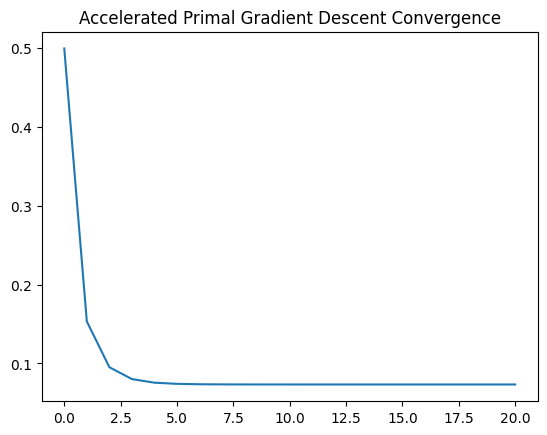

Time taken to run accelerated gradient descent:  0.9117424488067627


In [5]:
start = time.time()
objective_values_primal = accelerated_gradient_descent_primal()
end = time.time()
print("Time taken to run accelerated gradient descent: ", end - start)


0 0.0
1 0.05368986404002332
2 0.05372826808452319
3 0.05377458827152591
4 0.05382852527091826
5 0.05388979999127342
6 0.0539581373452889
7 0.054033258828850655
8 0.05411487903931707
9 0.05420270420578745
10 0.05429643184891432
11 0.05439575111990456
12 0.05450034356801308
13 0.05460988418625785
14 0.05472404263916004
15 0.05484248460715438
16 0.054964873200824965
17 0.055090870409779
18 0.055220138558670105
19 0.05535234174822521
20 0.05548714726302532
21 0.055624226930786475
22 0.05576325842030339
23 0.055903926467257864
24 0.0560459240188804
25 0.05618895329006499
26 0.05633272672501878
27 0.05647696785991178
28 0.05662141208329319
29 0.056765807292265734
30 0.05690991444356487
31 0.05705350799977388
32 0.057196376271915934
33 0.057338321660601196
34 0.05747916079876167
35 0.05761872459978281
36 0.05775685821552946
37 0.05789342090936748
38 0.058028285849796336
39 0.058161339830734564
40 0.05829248292483671
41 0.05842162807647172
42 0.0585487006411564
43 0.05867363787832309
44 0.0587

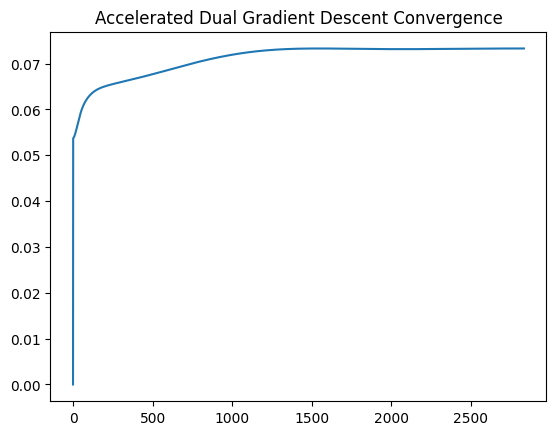

Time taken to run accelerated gradient ascent:  4.162924289703369


In [6]:
start = time.time()
objective_values_dual = accelerated_gradient_ascent_dual()
end = time.time()
print("Time taken to run accelerated gradient ascent: ", end - start)

In [7]:
# the constant involved in algorithmic complexity

(lambda_max/lambda_min)*(L_rho/mu_rho)

272698.34460884635

0.07328822126095963
0 0.12863622216518839
1 0.12985760176922784
2 0.1287475639955695
3 0.1297096696253425
4 0.1288303455302795
5 0.1295876429082678
6 0.12889052167737658
7 0.12948603969812955
8 0.12893281438414875
9 0.12940054490474073
10 0.12896096476162494
11 0.12932775949676287
12 0.1289779348550264
13 0.12926500451447615
14 0.1289860686530982
15 0.1292101675774201
16 0.12898722028266382
17 0.1291615824584149
18 0.1289828559034331
19 0.12911793447627357
20 0.12897413458607562
21 0.1290781860884614
22 0.12896197244075197
23 0.1290415183183031
24 0.1289470934245609
25 0.12900728461536026
26 0.12893006956702144
27 0.12897497449118417
28 0.12891135280293123
29 0.12894418484418024
30 0.12889130015067524
31 0.1289145973424194
32 0.12887019362506372
33 0.1288859605777781
34 0.12884825597692925
35 0.12885807598233256
36 0.1288256631361335
37 0.12883078671267054
38 0.12880255404320526
39 0.1288039688741332
40 0.1287790384198258
41 0.12877752459235356
42 0.12875520290738576
43 0.1287513765443

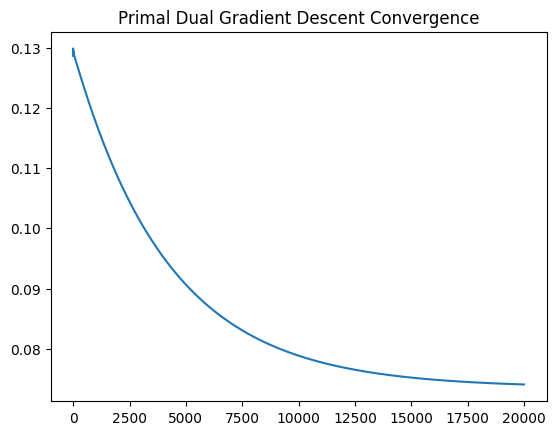

Time taken to run PD gradient descent:  542.786979675293


In [8]:
start = time.time()
objective_values_pd = primal_dual_gradient_descent(lagrangian, lagrangian_gradient_primal, lagrangian_gradient_dual, 1e-6)
end = time.time()
print("Time taken to run PD gradient descent: ", end - start)

#### c

Compare the three algorithms using cpu-time vs objective plots across iterations. Inherently solving saddle-point form is more efficient than solving the primal/dual. Do you observe this from the plots?

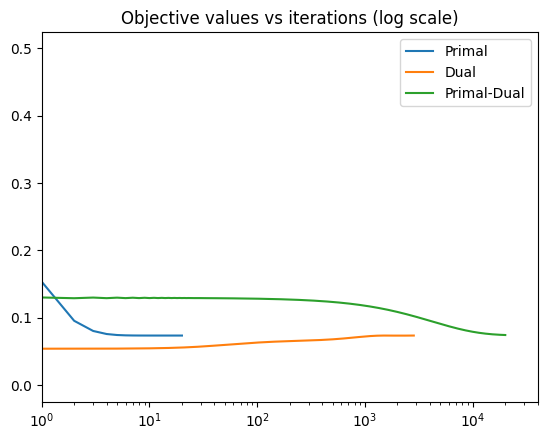

In [9]:
# plot the objective values vs iterations (log scale) for all three methods

plt.plot(objective_values_primal, label="Primal")
plt.plot(objective_values_dual, label="Dual")
plt.plot(objective_values_pd, label="Primal-Dual")
plt.xscale("log")
plt.xlim(1, 2*np.max([len(objective_values_primal), len(objective_values_dual), len(objective_values_pd)]))
plt.legend()
plt.title("Objective values vs iterations (log scale)")
plt.show()

#### d

Now if the regularizer in (7) is $\|\theta\|_1$, derive the saddle-point and dual formulations. Highlight the formula for computing the primal solution using the dual solution

The primal objective with $\ell_1$ regularizer is given by:

$$
\text{MSPBE}(\theta) = \frac{1}{2} \| \hat A \theta - \hat b \|^2_{\hat C^{-1}} + \rho \| \theta \|_1
$$

The saddle-point formulation for the regularizer $\|\theta\|_1$ is given by:

$$
\mathcal{L}(\theta, w) = \frac{\rho}{2} \| \theta \|_1 - w^T \hat A \theta - (\frac{1}{2} w^T \hat C w - w^T \hat b)
$$

The dual objective can be derived by taking the Fenchel dual of the primal objective:

$$
g(w) = \frac{1}{2} w^TCw - w^Tb + I_{A^Tw}(\rho/2)
$$

where $I_{x}(r)$ is the indicator function of the set $\{x: \|x\|_{\infty} \leq r\}$, that is

$$
I_{x}(r) = \begin{cases}
0 & \text{if } \|x\|_{\infty} \leq r\\
\infty & \text{otherwise}
\end{cases}
$$

To compute the primal solution using the dual solution, we can use the following formula:

$$
\theta^* = A^{-1} (b - Cw^*)
$$

where $w^*$ is the optimal dual solution.

In [10]:
def primal_objective_l1(theta):
    return 0.5*((A @ theta - b).T @ np.linalg.pinv(C) @ (A @ theta - b) + (rho/2)*np.linalg.norm(theta, ord=1))

def primal_gradient_l1(theta):
    # return A.T @ np.linalg.pinv(C) @ (A @ theta - b) + (rho/2) * np.sign(theta)
    return A.T @ np.linalg.pinv(C) @ (A @ theta - b)

def dual_objective_l1(w):
    return - 0.5 *  w.T @ C @ w + w.T @ b

def dual_gradient_l1(w):
    return - C @ w + b

def lagrangian_l1(theta, w):
    return (rho/2) * np.linalg.norm(theta, ord=1) - w.T @ A @ theta - 0.5 * w.T @ C @ w + w.T @ b

def lagrangian_gradient_primal_l1(theta, w):
    return (rho/2) * np.sign(theta) - A.T @ w

def lagrangian_gradient_dual_l1(theta, w):
    return b - (A @ theta) - (C @ w)

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def projection(x, threshold):
    # x[x<0] = np.maximum(x[x<0], -threshold)
    # x[x>0] = np.minimum(x[x>0], threshold)
    # return x
    return np.clip(x, -threshold, threshold)

#### f

On the same synthetic dataset, compare primal accelerated proximal gradient vs dual accelerated proximal gradient vs your proposed primal-proximal-dual-gradient method using cpu-time vs objective plots across iterations. What is your observation from the plots?

In [11]:
def proximal_gradient_descent_primal(epsilon):
    x_prev = x = np.zeros(n)
    time_stamps, objective_values = [], []
    i = 0
    l = 1
    l_prev = 0
    z = x.copy()
    Lr = np.linalg.norm(A) ** 2

    start = time.time()
    while True:
        x_prev = x.copy()
        # z = z + A.T.dot(b - A.dot(z))/Lr
        z = z - (1/Lr + 1/(i+1)) * primal_gradient_l1(z)
        x = soft_thresholding(z, rho/(2*Lr))
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        z = x + (l_prev - 1)/l * (x - x_prev)
        
        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))

        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - objective_values[-2]) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Accelerated Proximal Gradient Descent Convergence on Primal L1')
    plt.show()
    return objective_values, time_stamps

def proximal_gradient_ascent_dual(epsilon):
    w_prev = w = np.zeros(n)
    time_stamps, objective_values = [], []
    i = 0
    l = 1
    l_prev = 0
    z = w.copy()
    Lr = np.linalg.norm(C)

    start = time.time()
    while True:
        w_prev = w.copy()
        z = z + 1/Lr * dual_gradient_l1(z)
        w = projection(z, rho/2)
        l_prev = l
        l = 0.5 * (1 + np.sqrt(1 + 4*l**2))
        z = w + (l_prev - 1)/l * (w - w_prev)

        time_stamps.append(time.time() - start) 
        objective_values.append(dual_objective_l1(w))
        
        print(i, dual_objective_l1(w))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - objective_values[-2]) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Accelerated Proximal Gradient Descent Convergence on Dual L1')
    plt.show()
    return objective_values, time_stamps

0 0.1516473352020595
1 0.154244163710867
2 0.15225459294666285
3 0.1470058602655265
4 0.1404841768380411
5 0.1353466485526209
6 0.13208388636406307
7 0.13065649389012568
8 0.13016508377413175
9 0.1300425164555538
10 0.13003269536326817
11 0.13003270067982223


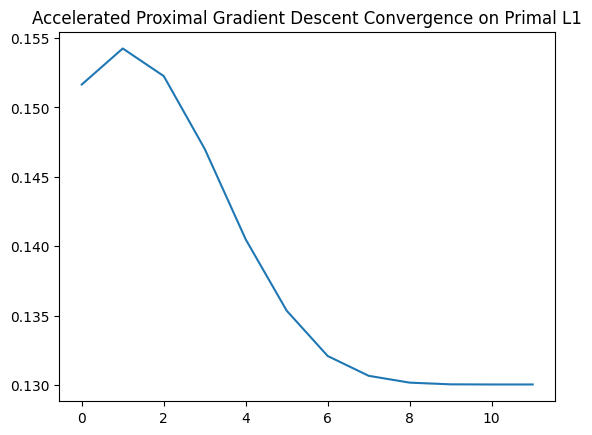

Time taken to run proximal gradient descent:  0.5494740009307861


In [12]:
start = time.time()
objective_values_primal_l1, time_stamps_primal_l1 = proximal_gradient_descent_primal(1e-6)
end = time.time()
print("Time taken to run proximal gradient descent: ", end - start)

0 0.12639132946601722
1 0.12640369639672358
2 0.12641943686138907
3 0.1264384248090149
4 0.12646053889905184
5 0.12648566606998096
6 0.12651369480798516
7 0.12654451202335587
8 0.12657800153891885
9 0.12661404340237714
10 0.12665251366258468
11 0.1266932844268035
12 0.12673622409777083
13 0.1267811977304879
14 0.1268280674707145
15 0.1268766930496781
16 0.12692693231696117
17 0.12697864179815593
18 0.1270316772668673
19 0.1270858943226523
20 0.1271411489678985
21 0.12719729817766984
22 0.1272542004573473
23 0.12731171638352393
24 0.1273697091241533
25 0.12742804493441806
26 0.12748659362521472
27 0.1275452290015451
28 0.12760382926848304
29 0.12766227740274932
30 0.12772046148827634
31 0.12777827501449104
32 0.12783561713637415
33 0.1278923928956823
34 0.12794851340303404
35 0.12800389598086415
36 0.1280584642675465
37 0.12811214828326228
38 0.12816488445845933
39 0.1282166156259933
40 0.12826729097827644
41 0.12831686599097245
42 0.12836530231496865
43 0.12841256763853265
44 0.1284586

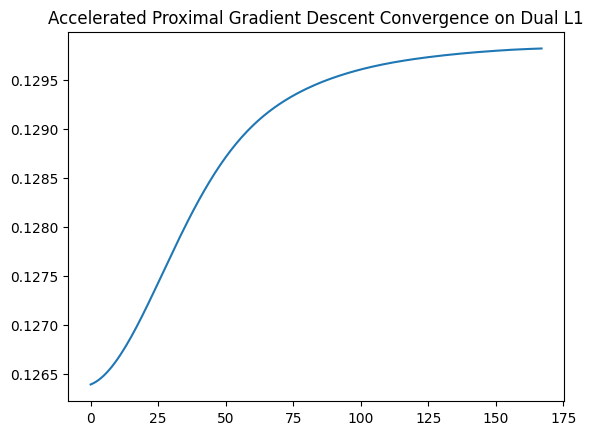

Time taken to run proximal gradient descent:  0.1936652660369873


In [13]:
start = time.time()
objective_values_dual_l1, time_stamps_dual_l1 = proximal_gradient_ascent_dual(1e-6)
end = time.time()
print("Time taken to run proximal gradient descent: ", end - start)

In [14]:
def coordinate_prox_gradient_descent_primal(epsilon):
    x = np.ones(n)
    time_stamps, objective_values = [], []
    i = 0
    start = time.time()
    while True:
        for j in range(n):
            # x[j] = soft_thresholding(x[j] + A[j].dot(b - A.dot(x))/L, rho/L)
            x[j] = soft_thresholding(x[j] - 2/L * primal_gradient_l1(x)[j], rho/(2*L))
        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))
        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - objective_values[-2]) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Coordinate Proximal Gradient Descent Convergence on Primal L1')
    plt.show()
    return objective_values, time_stamps

0 1.553871288042722
1 0.43893467635865985
2 0.17640562076581773
3 0.1318134717661587
4 0.13042726400998317
5 0.13041612926378926
6 0.1304053087086432
7 0.1303947934787675
8 0.13038457495879716
9 0.1303746447764813
10 0.13036499479572933
11 0.13035561711009824
12 0.13034650403608872
13 0.13033764810711568
14 0.1303290420673668
15 0.1303206788657307
16 0.13031255164955233
17 0.13030465376077718
18 0.13029697872782267
19 0.13028952026251325
20 0.13028227225402245
21 0.13027522876353426
22 0.13026838402051774
23 0.13026173241668268
24 0.13025526850227642
25 0.13024898698110327
26 0.1302428827067104
27 0.1302369506775239
28 0.13023118603358852
29 0.13022558405112977
30 0.13022014014103508
31 0.13021484984259063
32 0.1302097088212962
33 0.1302047128649682
34 0.13019985788042387
35 0.1301951398898019
36 0.13019055502735907
37 0.13018609953690238
38 0.1301817697675807
39 0.13017756217216517
40 0.13017347330301055
41 0.13016949981016823
42 0.13016563843813345
43 0.13016188602305184
44 0.1301582

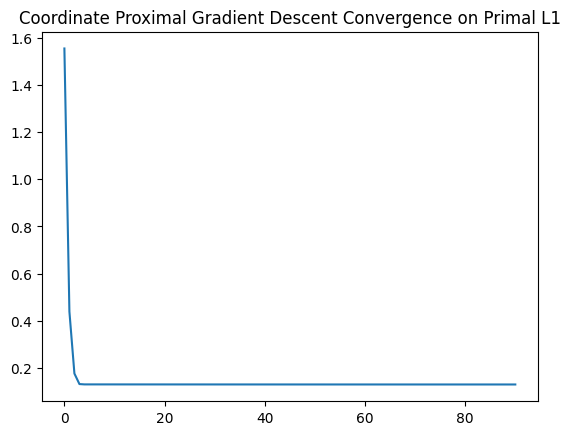

Time taken to run coordinate proximal gradient descent:  166.28683853149414


In [15]:
start = time.time()
objective_values_coord_l1, time_stamps_coord_l1 = coordinate_prox_gradient_descent_primal(1e-6)
end = time.time()
print("Time taken to run coordinate proximal gradient descent: ", end - start)

#### e

Propose an analogous algorithm for this case which does block coordinate optimization using proximal steps for the primal variable and gradient steps for the dual variable. Code this

In [16]:
def coordinate_prox_gradient_descent_primal_dual(epsilon):
    x = np.zeros(n)
    w = np.zeros(n)
    xold = x
    wold = w
    time_stamps, objective_values = [], []
    i = 0
    Lr = np.linalg.norm(A) ** 2
    start = time.time()
    while True:
        for j in range(n):
            x[j] = soft_thresholding(x[j] - (1/Lr + 1/(i+1)) * (rho/2) * (np.sign(x) - A.T @ wold)[j], rho/(20*Lr))
        for j in range(n):
            w[j] = w[j] + (1/Lr + 1/(i+1)) * (b - (A @ xold) - (C @ w))[j]

        time_stamps.append(time.time() - start)
        objective_values.append(primal_objective_l1(x))
        print(i, primal_objective_l1(x))
        i+=1
        if (i>2 and np.abs(objective_values[-1] - objective_values[-2]) < epsilon )or i>20_000:
            break

    plt.plot(objective_values)
    plt.title('Coordinate Proximal Primal-Dual GD on L1')
    plt.show()
    return objective_values, time_stamps

0 0.13003840981614084
1 0.13005870520751567
2 0.13499587051951673
3 0.13044276416117234
4 0.13100466646275316
5 0.1300459628573427
6 0.13044825586790088
7 0.1300443112648609
8 0.13039617533171016
9 0.1300457348602869
10 0.13035656999195866
11 0.13004856068442247
12 0.13032436139810646
13 0.13005208500111315
14 0.13029698065229048
15 0.1300559704676367
16 0.13027297460467444
17 0.13006004042510808
18 0.13025145185565498
19 0.13006419645165734
20 0.13023183084131257
21 0.13006838128553266
22 0.13021371327270767
23 0.13007256063926942
24 0.1301968154600841
25 0.1300767136552811
26 0.13018092867774314
27 0.1300808276179286
28 0.13016589511195584
29 0.1300848948903874
30 0.13015159263521814
31 0.13008891107649115
32 0.13013792482314515
33 0.13009287388120433
34 0.13012481420191474
35 0.1300967823874295
36 0.1301121975599673
37 0.1301006365860642
38 0.13010002261716921


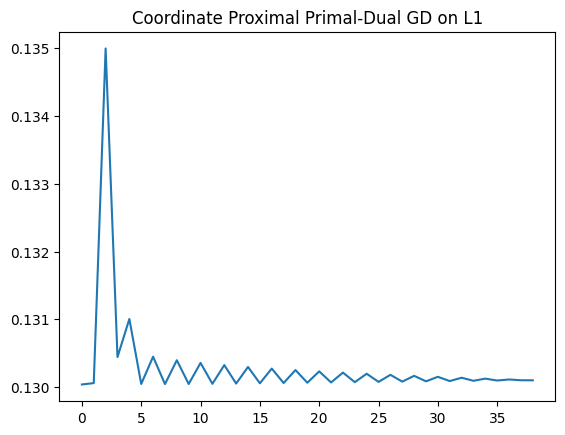

Time taken to run coordinate proximal gradient descent:  1.2664082050323486


In [17]:
start = time.time()
objective_values_pd_l1, time_stamps_pd_l1 = coordinate_prox_gradient_descent_primal_dual(1e-6)
end = time.time()
print("Time taken to run coordinate proximal gradient descent: ", end - start)

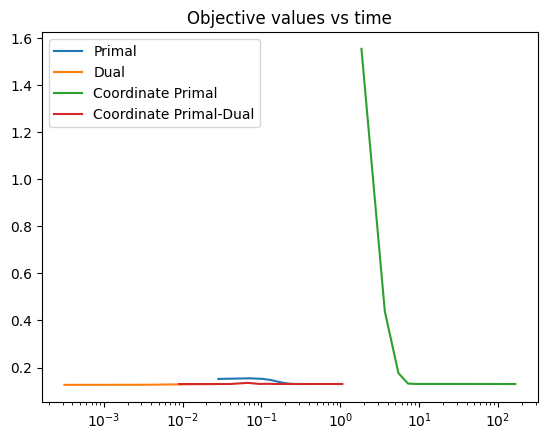

In [18]:
# plot the objective values vs time for all three methods

plt.plot(time_stamps_primal_l1, objective_values_primal_l1, label="Primal")
plt.plot(time_stamps_dual_l1, objective_values_dual_l1, label="Dual")
plt.plot(time_stamps_coord_l1, objective_values_coord_l1, label="Coordinate Primal")
plt.plot(time_stamps_pd_l1, objective_values_pd_l1, label="Coordinate Primal-Dual")
plt.legend()
plt.xscale("log")
plt.title("Objective values vs time")
plt.show()


#### g

Now, consider a high-dimensional setting where $n << d$. Then, will the primal acc.gr. descent be still as computationally efficient as the dual acc.gr. descent? With theoretical arguments, in this setting, can you compare the efficiency of primal-dual vs dual algorithms. Is there a trade-off or is there a clear winner ?

Ans.

For the first part, we cannot really say. The complexity of the primal accelerated gradient descent is $O(d^3 \log(1/\epsilon))$, while the complexity of the dual accelerated gradient descent is $O(d^{2.3} /\epsilon^2)$. We need information about $\epsilon$ to compare the two.

For the second part, we can say that the primal-dual algorithm is more efficient than the dual algorithm. The primal-dual algorithm has a complexity of $O(d^2 \log(1/\epsilon))$, while the dual algorithm has a complexity of $O(d^{2.3} /\epsilon^2)$. The primal-dual algorithm is more efficient than the dual algorithm. However, for practical use, the dual algorithm seems to be more practical, as it has lower runtimes. This can be understood from the plots in the previous parts. One reason for this could be the explosive constants involved in the complexity of the primal-dual algorithm.

Thank You!